## **Outline**

- Introduction to GANs
  - Recap of Generative Adversarial Networks (GANs)
- Understanding GAN Architecture: Generator and Discriminator
- Implementing a Basic GAN for Generating Images
- Training and Evaluating the GAN


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## Generative Adversarial Networks

- **Image classification**: Assigning a label to an image based on its content.
- Convolutional Neural Networks (CNNs) have brought groundbreaking changes in this field.
- CNNs are specialized neural networks for processing grid-like data (e.g., images).

- Extending CNNs to Generate Images
  - A fascinating feature of CNNs:
    - Their adaptability
  - While they excel in classification, they can also be repurposed to generate images
  - Think of it as "reverse engineering"
    - Given the learned features, how might an image look?


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **GANs**

- GANs: The New Era of Image Generation
  - A novel architecture involving two networks: A generator and a discriminator.
  - These networks train together, continuously improving each other.
  - The goal?
    - Have the generator create images so good that the discriminator can't tell them apart from real ones.

- GANs in Action: A Real-world Analogy
  - Picture a bank (the discriminator) trying to spot fake money from a counterfeiter (the generator).
  - Initially, the counterfeiter's fakes are obvious.
    - But let the money forger have a spy in the bank that reports back how the bank is telling fakes apart from real money.
  - A continuous cycle of adaptation and counter-adaptation ensues.


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **GANs Components**

- The Discriminator and Generator in Detail
  - **Discriminator**: A CNN trained to assign a probability that an image is real.
  - **Generator**: A specialized CNN using transpose convolutions (or deconvolutions). It starts with random noise (around 100 parameters) and crafts an image from it.


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/GAN6.png?raw=1" width="500" align="center"/>


- How Does the Discriminator "Guide" the Generator?
  - The *discriminator*, being a convolutional neural network, is differentiable
  - By backpropagating, we can identify the gradients of the input image
  - These gradients inform the *generator* which parts of the image to tweak

- Utilizing the Feedback
  - With the gradient information, we can adjust the weights of the generative network.
  - This ensures that subsequent images produced by the generator are more "authentic" in appearance.

- A Continuous Tug-of-War
  - The discriminator seeks disparities between fake and real images.
  - The generator aims to blur these lines of differentiation.
  - Over time, this competition refines the generator to a point where its output becomes indistinguishable from real images.

- Real-world Implementation
  - Implementing GANs requires a deep learning framework, e.g., PyTorch.
  - The true test: Training the network on diverse image datasets like CIFAR-10 or 64x64 Imagenet samples.
  

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **CIFAR Dataset Overview**

- **Description**: A collection of small images in 10 distinct classes.
- **Image Size**: 32x32 pixels (color images).
- **Number of Images**: 60,000
    - 50,000 training images
    - 10,000 testing images
- **Classes**: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>


Generated CIFAR images on iteration 300, 900, and 5700.

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/GAN2.png?raw=1" align="center"/>

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

Real images on the left, generated at iteration 182,000 on the right

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/GAN3.png?raw=1" align="center"/>

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

What happens if we scale it up?
- CIFAR is only 32x32, so let's try Imagenet.
- I downloaded a 150,000 image set from the Imagenet 2012 Challenge, and rescaled them all to 64x64.

- Generated Imagenet images on iteration 300, 800, and 5800.

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/GAN4.jpeg?raw=1" width="500" align="center"/>


- Real images on the left, generated at iteration 17,800 on the right

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/GAN5.jpeg?raw=1" width="500" align="center"/>


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **Genereative Adversarial Networks**


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/gan_architecture.png?raw=1" width="70%"/>

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.8

# Learning rate for the optimizer (affects how fast the model learns)
lr = 2e-4

# Weight decay for regularization in the optimizer (prevents overfitting by penalizing large weights)
weight_decay = 8e-9

# Beta1 parameter for the Adam optimizer (momentum term for the moving average of the gradient)
beta1 = 0.5

# Beta2 parameter for the Adam optimizer (momentum term for the moving average of the squared gradient)
beta2 = 0.999

batch_size = 256

epochs = 10

# Specifies how frequently to plot or visualize metrics/results (e.g., after every 10 training steps)
plot_every = 10


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **Generator**

- Its primary role is to produce or *"generate"* data.

- **Latent Vector:** The Starting Point
  - Generators begin with a random vector.
  - This is similar to the latent vector used in autoencoders
  - Acts as the seed or source from which data will be generated.

- **How Does the Generator Produce Images?**
  - Transforms the initial random vector.
  - Uses a series of neural network layers to shape and refine this vector.
  - The output is our target image.

- **Parallels with Autoencoders**
  - The generator's process mirrors the generative side of an autoencoder.
  - Both start with a compressed representation (latent vector) and expand it.
  - However, while autoencoders reconstruct from known data, generators create new data.

- **Building a Generator**
  - Many architectures can be employed.
    - Linear neural networks are one such choice.
  - The choice of architecture can be influenced by the dataset in use.


In our example, we will use linear neural networks and MNIST dataset.


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

In [3]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Linear layer mapping from a 100-dimensional latent space to 256 dimensions.
        # This will learn the first hidden layer of the generator.
        self.linear1 = nn.Linear(100, 256)

        # Batch normalization layer to stabilize and speed up training.
        # It is applied to the 256-dimensional output from the previous layer.
        # "momentum" parameter is typically set between 0.1 and 0.3 to control
        # the amount of exponential decay applied to the running mean and variance.
        self.bn1 = nn.BatchNorm1d(256, momentum=0.2)

        # Another linear layer that upscales the feature to 512 dimensions.
        self.linear2 = nn.Linear(256, 512)
        # Batch normalization for the 512-dimensional vector.
        self.bn2 = nn.BatchNorm1d(512, momentum=0.2)

        # Linear layer which transforms 512 features to 1024 features.
        self.linear3 = nn.Linear(512, 1024)
        # Batch normalization for the 1024-dimensional vector.
        self.bn3 = nn.BatchNorm1d(1024, momentum=0.2)

        # Final linear layer which maps 1024 features to 784.
        # Considering we are possibly dealing with 28x28 images (as 28x28 == 784),
        # this layer will output something that can be reshaped into a 28x28 image.
        self.linear4 = nn.Linear(1024, 784)

        # Tanh activation function for the output layer.
        # Tanh is commonly used in the output layer of a GAN generator
        # as it maps outputs to be within the range [-1, 1].
        self.tanh = nn.Tanh()

        # LeakyReLU activation function for hidden layers with a small negative slope of 0.2.
        # This slight negative slope allows gradients to flow even when the unit is not active,
        # avoiding dead neurons and aiding the training process.
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, input):
        # Forward pass through the first linear layer, followed by batch normalization,
        # and then through the LeakyReLU activation function.
        hidden1 = self.leaky_relu(self.bn1(self.linear1(input)))

        # Similarly for the second layer, the input (hidden1) passes through
        # a linear layer, batch normalization, and LeakyReLU.
        hidden2 = self.leaky_relu(self.bn2(self.linear2(hidden1)))

        # And the third hidden layer follows the same pattern.
        hidden3 = self.leaky_relu(self.bn3(self.linear3(hidden2)))

        # The output layer maps the activations via a linear transformation,
        # followed by a tanh activation function to squash values between -1 and 1.
        # After that, the output is reshaped (view()) to form a batch of images.
        # Here, [input.shape[0], 1, 28, 28] indicates [batch_size, channels, height, width].
        generated = self.tanh(self.linear4(hidden3)).view(input.shape[0], 1, 28, 28)

        # The reshaped tensor, which should now resemble images, is returned.
        return generated


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **Enhancing Generators: A Few Tricks**

Generative models often require a few tricks up their sleeves to improve stability and performance.

#### 1. LeakyReLU Activation

- Traditional ReLU: `f(x) = max(0, x)`
- **LeakyReLU**: A twist on the traditional ReLU.
  - Not strictly 0 for negative `x`.
  - Instead, it has a small positive gradient/slope.
  - Helps the network learn even for negative values of `x`.

#### 2. BatchNorm1D

- **BatchNorm1D**: A form of normalization applied to 1D inputs.
  - Helps in stabilizing training.
  - Can accelerate convergence.
  - Reduces the sensitivity to initialization.

#### 3. Tanh Activation for the Final Layer

- The **Tanh** activation function outputs values between [-1,1].
- Preferred for certain types of generative tasks.
- Ensures the generated data remains within a specific range.

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **Discriminator**

Discriminator is a classical image classification network. In our first example, we will also use linear classifier.

In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the first linear layer with 784 input nodes (for a flattened 28x28 image)
        # and 512 output nodes.
        self.linear1 = nn.Linear(784, 512)

        # Define the second linear layer that takes the 512 inputs from the previous layer
        # and reduces the dimension to 256.
        self.linear2 = nn.Linear(512, 256)

        # The final linear layer reduces the dimensions from 256 to a single node.
        # This single output node will output the probability of the input being real.
        self.linear3 = nn.Linear(256, 1)

        # LeakyReLU activation function with a negative slope of 0.2.
        # This will allow for a small, non-zero output for negative input values
        # and help to avoid dead neurons during training.
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Sigmoid activation function to squash the final output between 0 and 1,
        # allowing for binary classification (real vs. generated).
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        # Reshape the input image tensor into a flat tensor.
        # input.shape[0] likely refers to batch size, and -1 allows the function to
        # automatically calculate the size of the second dimension, ensuring the number
        # of elements in the tensor remains constant.
        input = input.view(input.shape[0], -1)

        # Forward pass through the first linear layer and then through the LeakyReLU.
        hidden1 = self.leaky_relu(self.linear1(input))

        # The output from the first layer (hidden1) goes through the second linear layer
        # and then through the LeakyReLU activation function.
        hidden2 = self.leaky_relu(self.linear2(hidden1))

        # The output (hidden2) goes through the final linear layer and then
        # the sigmoid activation function, providing a probability of the input being
        # a real image.
        classified = self.sigmoid(self.linear3(hidden2))

        # Return the final classification (probability of the input being real).
        return classified


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **Loading dataset**

We will use MNIST dataset.

In [5]:
def mnist(train_part, transform=None):
    # Download the MNIST dataset and apply the specified transformation (if any).
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)

    # Calculate the number of samples to use for training based on the specified train_part.
    train_part = int(train_part * len(dataset))

    # Randomly split the dataset into a training dataset and a test dataset.
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])

    # Return the training and test datasets.
    return train_dataset, test_dataset

In [6]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)
])

In [7]:
train_dataset, test_dataset = mnist(train_size, transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 43352649.65it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1228693.81it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10109622.12it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5700337.75it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )


# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **Network training**

On each step of the training, we have **two** phases:

**Generator training**
  - We generate some random vectors **noise** (training happens in minibatches, so we use 100 vectors at a time)
  - Generate **true labels** (vector with shape (bs, 1) with 1.0 values)
  - Calculate generator loss between output from **frozen** discriminator with noise as input and true labels.

**Discriminator training**
  - We calculate discriminator loss from **two** parts,
    - **first** part is loss between output from discriminator with noise as input
      - **fake labels** (vector with shape (bs, 1) with 0.0 values),
    - **second** part is loss between output from discriminator with real images as input and true labels (vector with shape (bs, 1) with 1.0 values).
    - **Result loss** is (first_part_loss + second_part_loss) / 2.

In [9]:
def plotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [10]:
def train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]

    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    for epoch in tqdm_iter:
        gen.train()
        disc.train()

        train_gen_loss = 0.0
        train_disc_loss = 0.0

        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)

            disc.eval()
            gen.zero_grad()
            # random vector
            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            #random vector to generator
            generated = gen(noise)
            #get predictions of real or fake from discriminator
            disc_preds = disc(generated)


            # get our loss on dicrimnator predictions vs actual labels
            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.train()
            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            plotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

  0%|          | 0/10 [00:00<?, ?it/s]

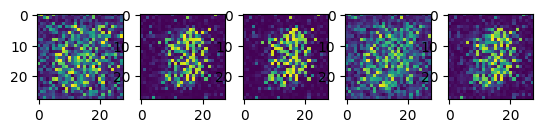

 90%|█████████ | 9/10 [03:09<00:20, 20.97s/it, generator loss:=0.993, discriminator loss:=0.567]

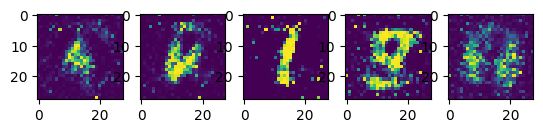

100%|██████████| 10/10 [03:31<00:00, 21.14s/it, generator loss:=0.965, discriminator loss:=0.578]


In [12]:
train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device)

In [13]:
print(models)

(Generator(
  (linear1): Linear(in_features=100, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=256, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=512, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=1024, out_features=784, bias=True)
  (tanh): Tanh()
  (leaky_relu): LeakyReLU(negative_slope=0.2)
), Discriminator(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
))


<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## **Hands on: Parameter Tuning**

- Experiment with different parameters including:
  - Learning rates for the generator and discriminator.
  - Different loss functions.
  - Different optimizer (e.g., SGD, Adam).

Testing with lr=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, loss_fn=BCELoss()


  0%|          | 0/10 [00:00<?, ?it/s]

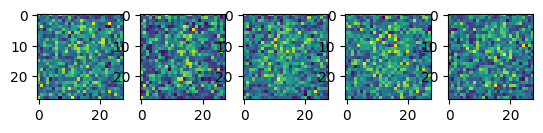

 90%|█████████ | 9/10 [02:56<00:19, 19.67s/it, generator loss:=1.08, discriminator loss:=0.476]

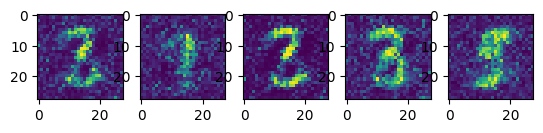

100%|██████████| 10/10 [03:16<00:00, 19.69s/it, generator loss:=1.14, discriminator loss:=0.44]


Testing with lr=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, loss_fn=MSELoss()


  0%|          | 0/10 [00:00<?, ?it/s]

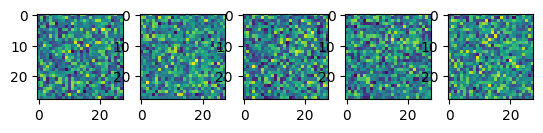

 90%|█████████ | 9/10 [02:54<00:19, 19.33s/it, generator loss:=0.282, discriminator loss:=0.186]

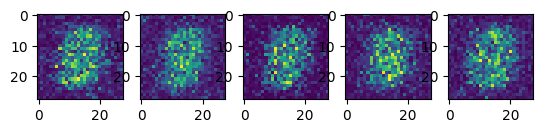

100%|██████████| 10/10 [03:14<00:00, 19.45s/it, generator loss:=0.297, discriminator loss:=0.18]


Testing with lr=0.01, optimizer=<class 'torch.optim.adam.Adam'>, loss_fn=BCELoss()


  0%|          | 0/10 [00:00<?, ?it/s]

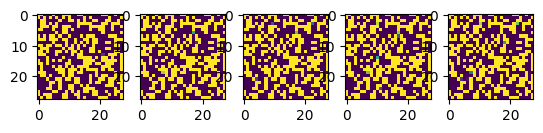

 90%|█████████ | 9/10 [03:04<00:20, 20.42s/it, generator loss:=100, discriminator loss:=0]

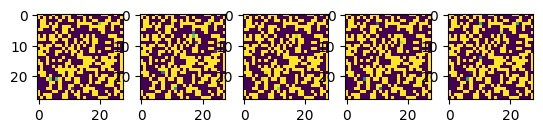

100%|██████████| 10/10 [03:25<00:00, 20.55s/it, generator loss:=100, discriminator loss:=0]


Testing with lr=0.01, optimizer=<class 'torch.optim.adam.Adam'>, loss_fn=MSELoss()


  0%|          | 0/10 [00:00<?, ?it/s]

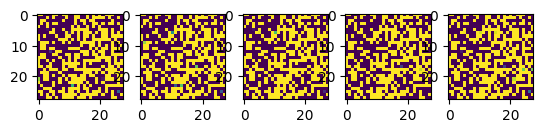

 90%|█████████ | 9/10 [03:04<00:20, 20.53s/it, generator loss:=1, discriminator loss:=0]

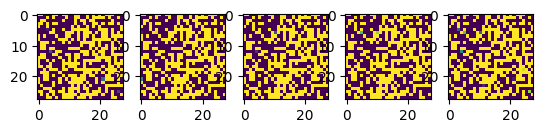

100%|██████████| 10/10 [03:25<00:00, 20.54s/it, generator loss:=1, discriminator loss:=0]


Testing with lr=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, loss_fn=BCELoss()


  0%|          | 0/10 [00:00<?, ?it/s]

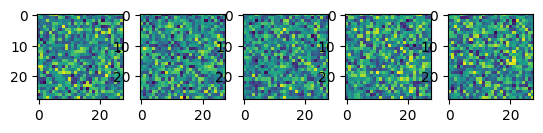

 90%|█████████ | 9/10 [02:56<00:19, 19.53s/it, generator loss:=0.676, discriminator loss:=0.422]

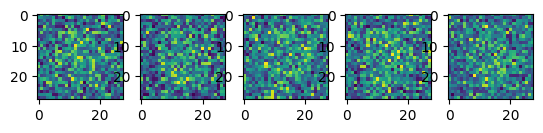

100%|██████████| 10/10 [03:16<00:00, 19.60s/it, generator loss:=0.678, discriminator loss:=0.431]


Testing with lr=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, loss_fn=MSELoss()


  0%|          | 0/10 [00:00<?, ?it/s]

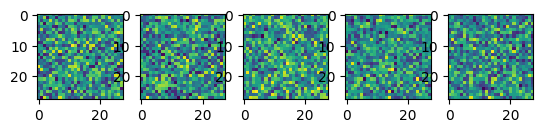

 90%|█████████ | 9/10 [02:56<00:19, 19.69s/it, generator loss:=0.25, discriminator loss:=0.134]

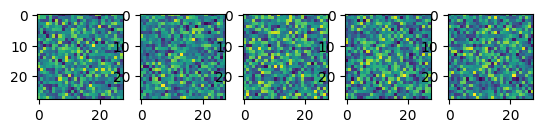

100%|██████████| 10/10 [03:16<00:00, 19.62s/it, generator loss:=0.252, discriminator loss:=0.133]


Testing with lr=0.001, optimizer=<class 'torch.optim.adam.Adam'>, loss_fn=BCELoss()


  0%|          | 0/10 [00:00<?, ?it/s]

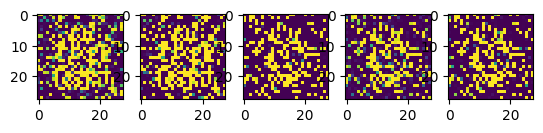

 90%|█████████ | 9/10 [03:05<00:20, 20.59s/it, generator loss:=13.3, discriminator loss:=0.00564]

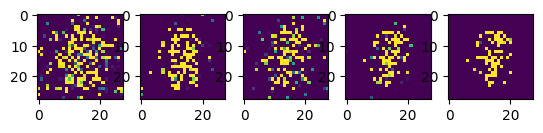

100%|██████████| 10/10 [03:26<00:00, 20.66s/it, generator loss:=19.3, discriminator loss:=0.0172]


Testing with lr=0.001, optimizer=<class 'torch.optim.adam.Adam'>, loss_fn=MSELoss()


  0%|          | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [17]:
# Hyperparameter sets to try
learning_rates = [1e-2, 1e-3, 1e-4]
optimizers = [torch.optim.SGD, torch.optim.Adam]
loss_fns = [nn.BCELoss(), nn.MSELoss()]

# Training Loop
for lr in learning_rates:
    for opt in optimizers:
        for loss_fn in loss_fns:
            train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
            dataloaders = (train_dataloader, )


            # Create a DataLoader for the test dataset
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            print(f'Testing with lr={lr}, optimizer={opt}, loss_fn={loss_fn}')
            generator = Generator().to(device)
            discriminator = Discriminator().to(device)

            optimizer_generator = opt(generator.parameters(), lr=lr)
            optimizer_discriminator = opt(discriminator.parameters(), lr=lr)

            models = (generator, discriminator)
            optimizers_local = (optimizer_generator, optimizer_discriminator)
            train_gan(dataloaders, models, optimizers_local, loss_fn, epochs, plot_every, device)

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

## DCGAN

**Deep Convolutional GAN** is pretty obvious idea of using convolutional layers for generator and discriminator. The main difference here is using **Conv2DTranspose** layer in the generator.



**Deep Convolutional GAN (DCGAN)** uses **transposed convolutional layers** to upscale the feature maps.

### What is Conv2DTranspose?

- A layer that performs the opposite of a convolution.
- Often called **"deconvolution"** (but note: it's not the mathematical inverse of convolution).
- Expands spatial dimensions: ⬜⬜ => 🔳🔳🔳🔳

### Why use it in DCGAN?

- **Generator** of DCGAN starts with a small spatial size (e.g., 1x1 or 4x4) and expands to the desired output size (e.g., 64x64).
- Transposed convolutions allow for **upsampling** feature maps while learning spatial distributions.

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/dcgan_generator.png?raw=1" width="60%"/>

> Image from [this tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

In [18]:
class DCGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.relu(self.bn1(self.conv1(input)))
        hidden2 = self.relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.relu(self.bn3(self.conv3(hidden2)))
        generated = self.tanh(self.conv4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

In [19]:
class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.leaky_relu(self.conv1(input))
        hidden2 = self.leaky_relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.conv3(hidden2)))
        classified = self.sigmoid(self.conv4(hidden3)).view(input.shape[0], -1)
        return classified

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

Weights initialization from [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) paper.

In [20]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [21]:
transform = transforms.Compose([
                                transforms.ToTensor(),
])

In [22]:
train_dataset, test_dataset = mnist(0.2*train_size, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

In [23]:
generator = DCGenerator().to(device)
generator.apply(weights_init)
discriminator = DCDiscriminator().to(device)
discriminator.apply(weights_init)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

In [24]:
def dcplotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100, 1, 1))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [25]:
def train_dcgan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]

    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    gen.train()
    disc.train()

    for epoch in tqdm_iter:
        train_gen_loss = 0.0
        train_disc_loss = 0.0

        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)
            imgs = 2.0 * imgs - 1.0

            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100, 1, 1))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            dcplotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

  0%|          | 0/5 [00:00<?, ?it/s]

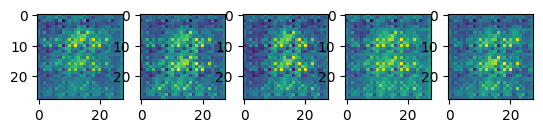

 80%|████████  | 4/5 [03:18<00:49, 49.51s/it, generator loss:=3.38, discriminator loss:=0.152]

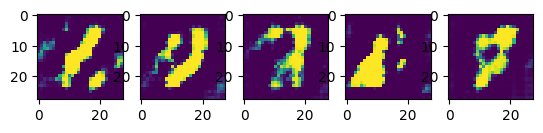

100%|██████████| 5/5 [04:08<00:00, 49.67s/it, generator loss:=2.29, discriminator loss:=0.322]


In [26]:
train_dcgan(dataloaders, models, optimizers, loss_fn, epochs // 2, plot_every // 2, device)

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

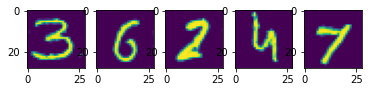

In [ ]:
generator.eval()
dcplotn(5, generator, device)

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>

> **Task**: Try generating more complex color images with DCGAN - for example, take one class from [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) dataset.

In [27]:
import torch
from torchvision import datasets, transforms

# Data transformation with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR-10 dataset
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to keep only airplanes (class index 0)
airplane_dataset = [data for data in full_dataset if data[1] == 0]

# DataLoader for the airplanes
dataloader = torch.utils.data.DataLoader(airplane_dataset, batch_size=128, shuffle=True)


100%|██████████| 170498071/170498071 [00:02<00:00, 81288716.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


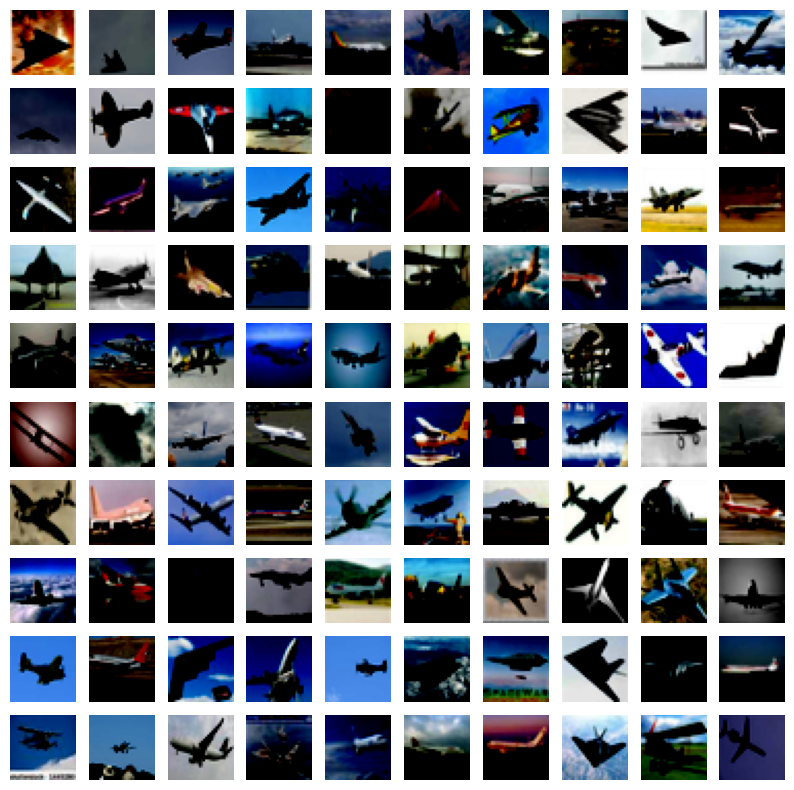

In [43]:
# prompt: show images in the airplane dataset above

import matplotlib.pyplot as plt

# Get a batch of images from the dataloader
images, labels = next(iter(dataloader))

# Show the images in a grid
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')

plt.show();


In [33]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 4 x 4
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 8 x 8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 16 x 16
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [35]:
import torch.optim as optim

# Create the generator and discriminator instances
netG = Generator()
netD = Discriminator()

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [37]:
import torchvision.utils as vutils

# Training Loop

# Number of epochs
num_epochs = 5

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z1)): %.4f\tD(G(z2)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/40]	Loss_D: 1.1986	Loss_G: 1.4394	D(x): 0.6479	D(G(z1)): 0.5185	D(G(z2)): 0.2442
[1/5][0/40]	Loss_D: 0.1433	Loss_G: 5.6297	D(x): 0.9328	D(G(z1)): 0.0660	D(G(z2)): 0.0040
[2/5][0/40]	Loss_D: 0.4237	Loss_G: 3.8961	D(x): 0.8223	D(G(z1)): 0.1610	D(G(z2)): 0.0245
[3/5][0/40]	Loss_D: 1.4919	Loss_G: 6.7180	D(x): 0.9683	D(G(z1)): 0.6619	D(G(z2)): 0.0030
[4/5][0/40]	Loss_D: 0.8509	Loss_G: 1.7352	D(x): 0.6114	D(G(z1)): 0.0939	D(G(z2)): 0.2455


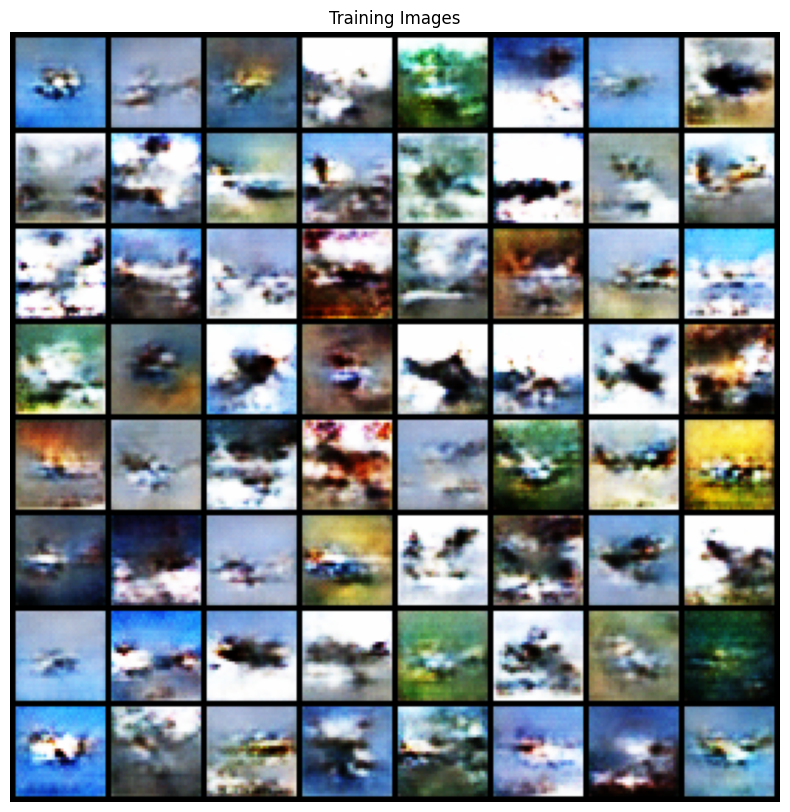

In [41]:
# Plotting the training progress images
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [39]:
import torchvision.utils as vutils

# Training Loop

# Number of epochs
num_epochs = 25

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z1)): %.4f\tD(G(z2)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/25][0/40]	Loss_D: 0.5717	Loss_G: 2.2976	D(x): 0.7696	D(G(z1)): 0.1849	D(G(z2)): 0.1268
[1/25][0/40]	Loss_D: 0.6570	Loss_G: 3.7579	D(x): 0.7410	D(G(z1)): 0.1973	D(G(z2)): 0.0384
[2/25][0/40]	Loss_D: 0.5401	Loss_G: 4.7708	D(x): 0.9065	D(G(z1)): 0.3157	D(G(z2)): 0.0125
[3/25][0/40]	Loss_D: 0.5043	Loss_G: 3.7665	D(x): 0.8173	D(G(z1)): 0.1664	D(G(z2)): 0.0441
[4/25][0/40]	Loss_D: 0.4762	Loss_G: 4.7462	D(x): 0.8827	D(G(z1)): 0.2452	D(G(z2)): 0.0173
[5/25][0/40]	Loss_D: 0.6241	Loss_G: 4.2739	D(x): 0.6571	D(G(z1)): 0.0328	D(G(z2)): 0.0440
[6/25][0/40]	Loss_D: 0.2931	Loss_G: 3.9513	D(x): 0.8874	D(G(z1)): 0.1373	D(G(z2)): 0.0324
[7/25][0/40]	Loss_D: 1.1751	Loss_G: 6.3476	D(x): 0.9507	D(G(z1)): 0.4818	D(G(z2)): 0.0039
[8/25][0/40]	Loss_D: 0.3398	Loss_G: 4.1955	D(x): 0.9148	D(G(z1)): 0.2000	D(G(z2)): 0.0210
[9/25][0/40]	Loss_D: 0.7981	Loss_G: 2.1615	D(x): 0.5603	D(G(z1)): 0.0261	D(G(z2)): 0.2233
[10/25][0/40]	Loss_D: 2.2766	Loss_G: 5.5062	D(x): 0.9896	D(G(z1)): 0.7578	

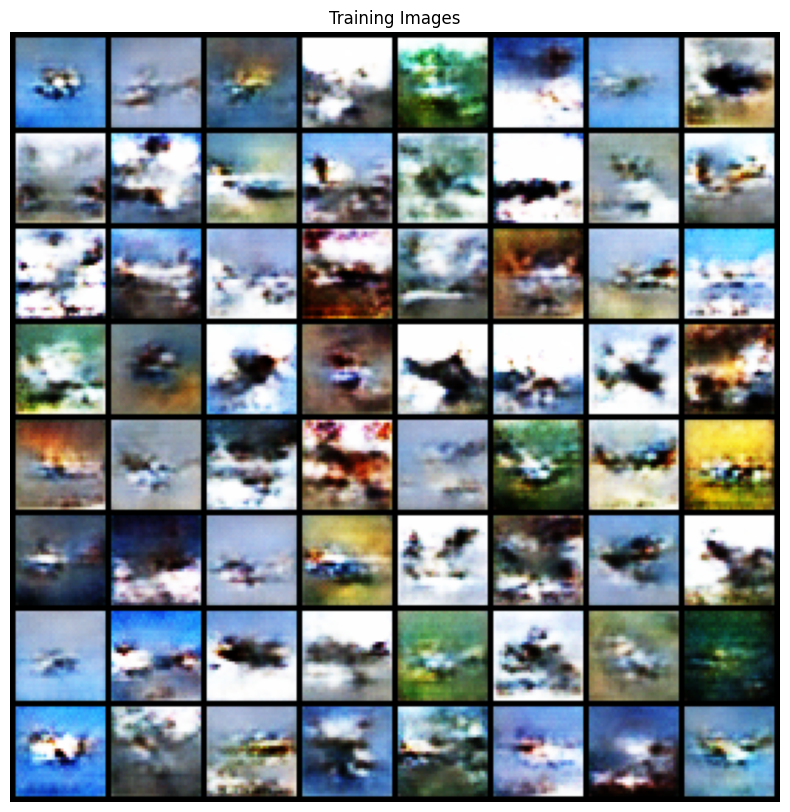

In [40]:
# Plotting the training progress images
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Training on Paintings

One of the good candidates for GAN training are paintings created by human artists.

![](https://soshnikov.com/images/artartificial/Flo1.jpg)

(Photo from [Art of Artificial](https://soshnikov.com/museum/art-artificial/) collection)

<img src="https://github.com/gregworks/Hands-on-Generative-AI/blob/main/Day-2/images/border.jpg?raw=1" height="10" width="1500" align="center"/>